# San Francisco Crime Prediction 

For our final project our group, ML_Watchers, participated in the SFO Crime Prediction Kaggle Competition. These data encompass 39 crimes that occured between 2011 and 2015 We are using the data provided about crimes that occurred in San Francisco from 2011 to 2015. The features described the times and locations of these crimes which were engineered for modeling purposes. Our initial attempt involved logistic regression and produced a baseline accuracy of about 20% which we improved to achieve an accuracy of 30%. In later attempts we used various machine learning classifiers from the sklearn package and keras package of python either in isolation or as ensembles with other techniques such as clustering and boosting.


## Initial Attempt

To get on the leaderboard, we did basic feature extraction and normalization, and used a logistric regression model. 

### Initial Feature Engineering Summary

These are the features we get in both training and test data sets.

| Date | DayOfWeek | PdDistrict | Address | Longitude | Latitude |
|---|---|---|---|---|---|---|---|
| 2015-05-10 23:59:00 | Sunday | BAYVIEW | 2000 Block of THOMAS AV | -122.3995877042 | 37.7350510104 |

For the initial attempt, we immediate made these modifications: 

* Semi-normalize years: subtract lowest year, 2011, so that year numbers are from 0 to 4. 
* Separate time information into year, month, day, time of day, day of week
* Normalize latitude and longitude (use (value - mean)/standard deviation)

And chose a logistic regression model for these reasons: 
* Predicting categorical dependent variable
* Relatively large number of samples, not so many features
* Mixture of categorical and continuous data
* Data with obvious correlation (so linear regression would be worse)
* Non-normally distributed data

The results of this attempt are summarized here: 

|  Model | Accuracy | Train Time | Kaggle Score |
|---|---|---|---|---|---|---|---|
| Logistic Regression | 31% | few minutes| 84th |
| Logistic Regression | 30%| few minutes | 105th |



In [13]:
%matplotlib inline 

# General Libraries
import operator
from string import capwords
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

# Keras
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils

from feature_engineering import *

## Data Exploration 

As predicted, simply plugging in data into a model did not yield good results. Although it gives us a baseline performance level to improve from, it was clear we needed to explore the data more thoroughly before moving forward trying new techniques.

### Importing raw data:

In [ ]:
data_df = pd.read_csv("../train.csv")
test_data_df = pd.read_csv("../test.csv")

for field, values in data_df.iteritems():
    print "Total number of Unique values for " + field + ": " + str(len(values.value_counts()))

### Creating plotting functions based on seaborn package
This allowed us to explore the distributions of features and labels

In [17]:
# Plotting Options
sns.set_style("whitegrid")
sns.despine()
def plot_bar(df, title, filename):
    p = (
        'Set2', 'Paired', 'colorblind', 'husl',
        'Set1', 'coolwarm', 'RdYlGn', 'spectral'
    )
    bar = df.plot(kind='barh',
                  title=title,
                  fontsize=10,
                  figsize=(12,8),
                  stacked=False,
                  width=1,
                  colors = sns.color_palette(np.random.choice(p), len(df)),
    )

    bar.figure.savefig(filename)
    
    plt.show()

def plot_top_crimes(df, column, title, fname, items=0):
    df.columns     = df.columns.map(operator.methodcaller('lower'))
    by_col         = df.groupby(column) 
    col_freq       = by_col.size()
    col_freq.index = col_freq.index.map(capwords)

    col_freq.sort(ascending=True, inplace=True)
    plot_bar(col_freq[slice(-1, - items, -1)], title, fname)

Total number of Unique values for Dates: 389257
Total number of Unique values for Category: 39
Total number of Unique values for Descript: 879
Total number of Unique values for DayOfWeek: 7
Total number of Unique values for PdDistrict: 10
Total number of Unique values for Resolution: 17
Total number of Unique values for Address: 23228
Total number of Unique values for X: 34243
Total number of Unique values for Y: 34243


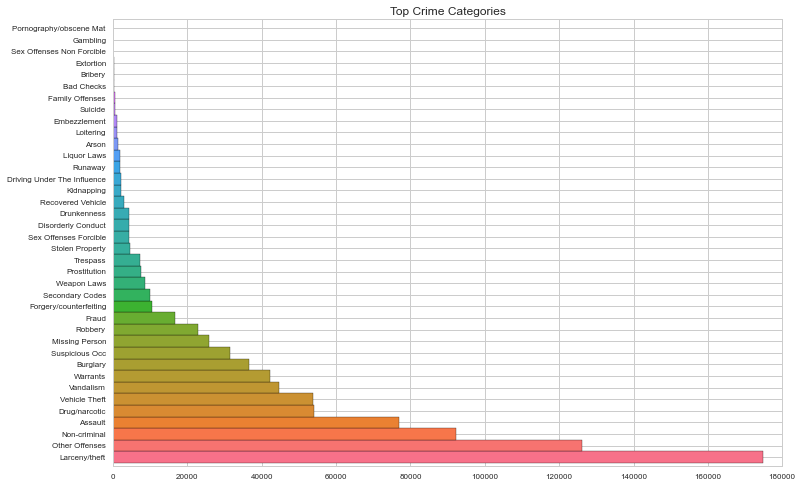

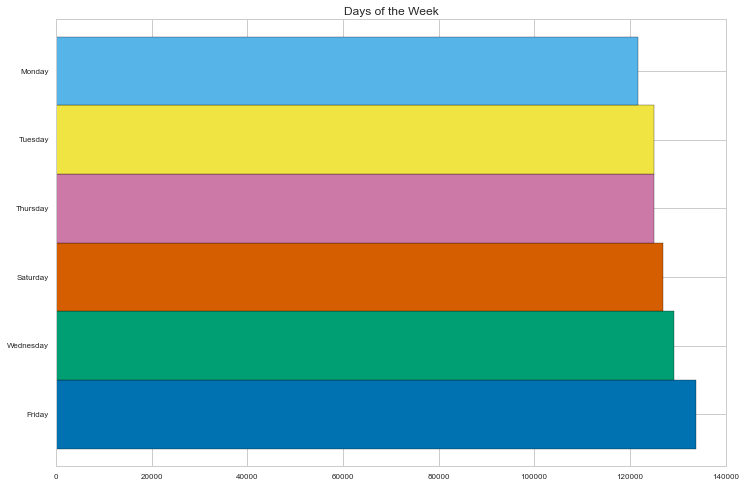

In [18]:
plot_top_crimes(data_df, 'category',   'Top Crime Categories',        'category.png')
plot_top_crimes(data_df, 'dayofweek',  'Days of the Week',            'weekly.png')

## Feature Engineering: Going Deeper

The initial features shown in the table above are converted into the features described below. The first 6 are based on **Date**, while the last 3 are based on **Address** (more details in sections below).
 
1. **Year**
2. **Month** - Value between 1-12
3. **Day of Month** - Value between 1-31
4. **Hour** - Value between 0-23
5. **Minute of Day** - Value between 0-1439. Calculated by the following formula: ```(hour * 60) + minute``` 
6. **Time of Day** - Categorical feature with the following possible values: Twilight (12 am to 6 am), Morning (6 am to 12 pm), Afternoon (12 pm to 6 pm), Night (6 pm to 12 am)
7. **Day of Week** - Categorical feature with 7 distinct values: Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday.
8. **District** - Categorical feature with 10 dictinct values: NORTHERN, PARK, INGLESIDE, BAYVIEW, RICHMOND, CENTRAL, TARAVAL, TENDERLOIN, MISSION, SOUTHERN.
9. **X** - X coordinates as float
10. **Y** - Y coordinates as float
11. **Block** - Categorical variable containing the block number (if not available it's assigned default/empty category). There are 85 distinct values.
12. **Street 1** - Categorical variable containing the first street/avenue/etc. There are 2033 distinct values.
13. **Street 2** - Categorical variable containing the second street/avenue/etc (if not available it's assigned default/empty category). There are 1694 distinct values. 
 
The categorical features, with the exception of the last 3 which we'll discuss later, are converted to dummy variables. That causes the number of features to expand based on the number of distinct values. For example, the **Time of Day** feature is converted to the following 4 features, each with possible values of 0 or 1:

* **IsTwilight**
* **IsMorning**
* **IsAfternoon**
* **IsNight**

As for the features based on **Address** (the last 3), they contained too many distinct values which made it impractical to use with our computers. As such, we first converted each one to a int value (Category1 = 0, Category2, 1, etc.) and then we used the sklearn.preprocessing.OneHotEncoder to convert all of them together into a sparse matrix which made it possible to hold in memory. Afterwards, we reduced the dimensionality to 20 columns using a truncated SVD (aka LSA). We managed to retain more than 44% of the variance.

Finally, we used the sklearn.preprocessing.StandardScaler to do feature scaling on all the numerical features.

## Final set of Features 

These are the features we were left with after feature engineering has been done:

![alt text](features.jpg "Features")


In [3]:
###########################################
# Prepare data and do feature engineering #
###########################################
fe = FeatureEngineering()
# Used to prepare the data the very first time. This does all of the feature engineering and generates the following
# two CSV files: train_processed.csv and test_processed.csv. After it's been run once on any computer, there's no 
# need to run it again if you just copy those files here.
#fe.prepare_data('train.csv', 'test.csv')

# These methods fetch the pre-processed data stored in train_processed.csv and test_processed.csv.
fe.load_train_data()
# If your PC has less than 8 GB of RAM you might run itno memory issues. If so, you might want to comment this out 
# until you need the data later.
fe.load_test_data()

# Examples of how to access the data (remove later)
print fe.train_data.shape
print fe.train_labels.shape
print fe.mini_train_data.shape
print fe.mini_train_labels.shape
print fe.dev_data.shape
print fe.dev_labels.shape
print fe.test_data.shape
print fe.test_labels.shape
print fe.submission_data.shape # Loaded by load_test_data()

# Examples of how to access categorical features (except Address) and labels.
print fe.districts
print fe.days_of_week
print fe.times_of_day
print fe.labels

Initializing
Loading train data
Shuffle the data and divide it into train, mini_train, dev and test sets
 + Status report:
    - Train data and labels: (580000L, 48L) - (580000L,)
    - Mini train data and labels: (10000L, 48L) - (10000L,)
    - Dev data and labels: (150000L, 48L) - (150000L,)
    - Test data and labels: (148049L, 48L) - (148049L,)

Loading test (submission) data
Converting test data into nparray
 + Status report:
    - Submission data: (884262L, 48L)

(580000L, 48L)
(580000L,)
(10000L, 48L)
(10000L,)
(150000L, 48L)
(150000L,)
(148049L, 48L)
(148049L,)
(884262L, 48L)
['NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL', 'TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN']
['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
['Twilight', 'Morning', 'Afternoon', 'Night']
{'VEHICLE THEFT': 36, 'SUICIDE': 31, 'WEAPON LAWS': 38, 'VANDALISM': 35, 'RECOVERED VEHICLE': 24, 'SECONDARY CODES': 27, 'WARRANTS': 37, 'DRUNKENNESS': 8, 'PROSTITUTION

## Data Exploration
Initial step was to explore the data. As part of this step, we did the following:
1. Number of Unique values for each and every variable
2. Find the most common values

Observations:
1. Invalid values present in Y coordinates (for example, Y = 90 which is invalid)
2. Detailed Address feature engineering is captured in an excel sheet.
3. Most crime was happening on Friday, closely followed by Wednesday

In [7]:
data_df = pd.read_csv("../train.csv")
test_data_df = pd.read_csv("../test.csv")

for field, values in data_df.iteritems():
    print "Total number of Unique values for " + field + ": " + str(len(values.value_counts()))

Total number of Unique values for Dates: 389257
Total number of Unique values for Category: 39
Total number of Unique values for Descript: 879
Total number of Unique values for DayOfWeek: 7
Total number of Unique values for PdDistrict: 10
Total number of Unique values for Resolution: 17
Total number of Unique values for Address: 23228
Total number of Unique values for X: 34243
Total number of Unique values for Y: 34243


### Plotting Function for Data Exploration

In [9]:
import operator
from string import capwords
import seaborn as sns

# Plotting Options
sns.set_style("whitegrid")
sns.despine()
def plot_bar(df, title, filename):
    p = (
        'Set2', 'Paired', 'colorblind', 'husl',
        'Set1', 'coolwarm', 'RdYlGn', 'spectral'
    )
    bar = df.plot(kind='barh',
                  title=title,
                  fontsize=8,
                  figsize=(12,8),
                  stacked=False,
                  width=1,
                  colors = sns.color_palette(np.random.choice(p), len(df)),
    )

    bar.figure.savefig(filename)
    
    plt.show()

def plot_top_crimes(df, column, title, fname, items=0):
    df.columns     = df.columns.map(operator.methodcaller('lower'))
    by_col         = df.groupby(column) 
    col_freq       = by_col.size()
    col_freq.index = col_freq.index.map(capwords)

    col_freq.sort(ascending=True, inplace=True)
    plot_bar(col_freq[slice(-1, - items, -1)], title, fname)

C:\Users\pgundugola\Downloads\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\pandas\tools\plotting.py:856: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


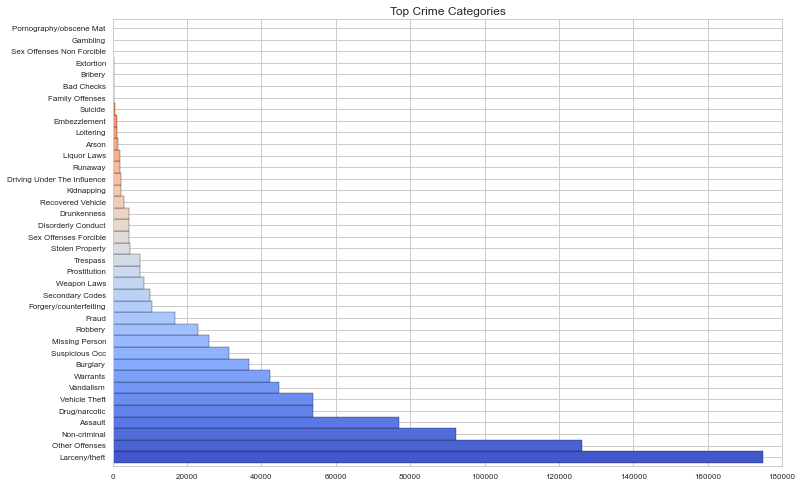

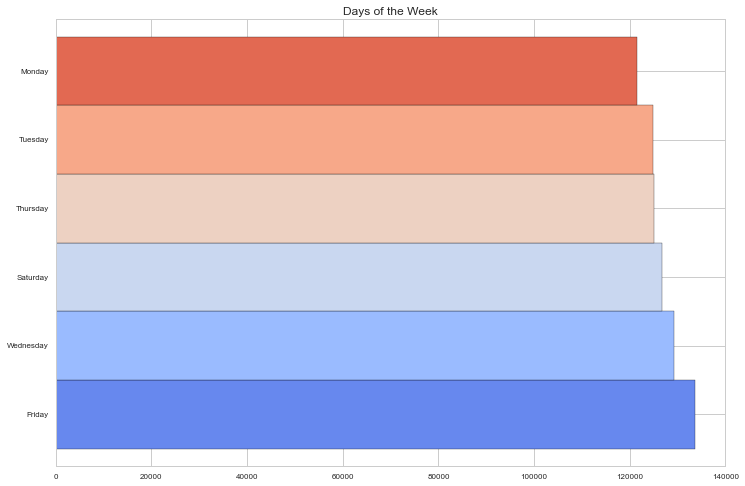

In [10]:
plot_top_crimes(data_df, 'category',   'Top Crime Categories',        'category.png')
plot_top_crimes(data_df, 'dayofweek',  'Days of the Week',            'weekly.png')

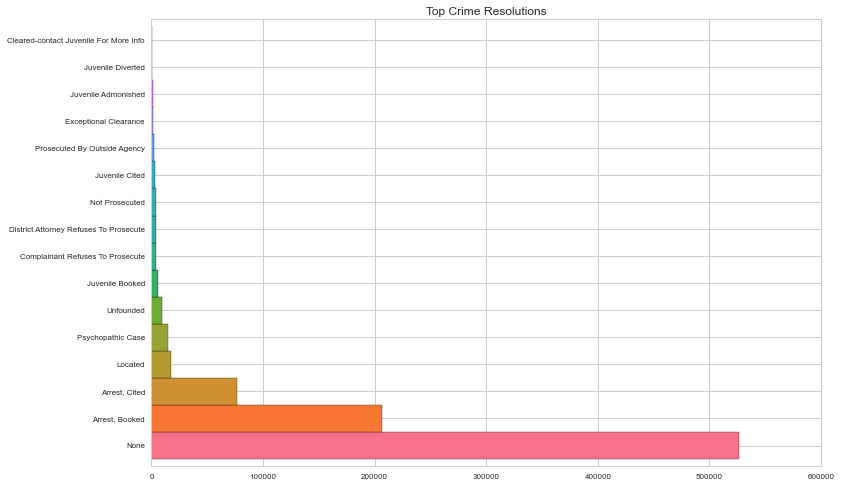

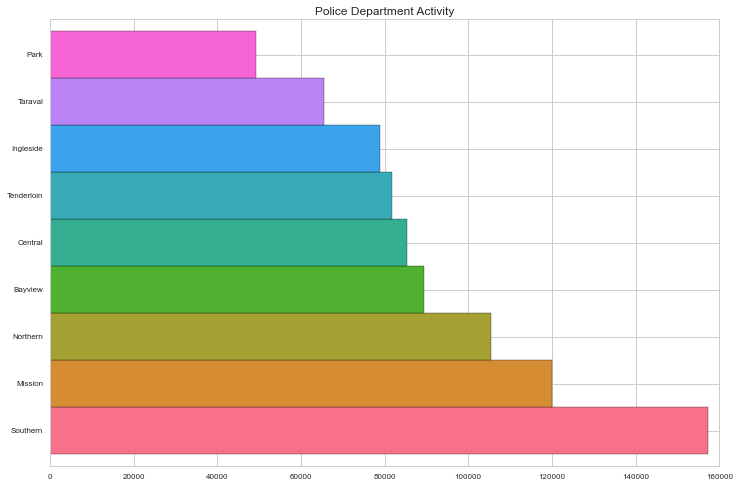

In [11]:
plot_top_crimes(data_df, 'resolution', 'Top Crime Resolutions',       'resolution.png')
plot_top_crimes(data_df, 'pddistrict', 'Police Department Activity',  'police.png')

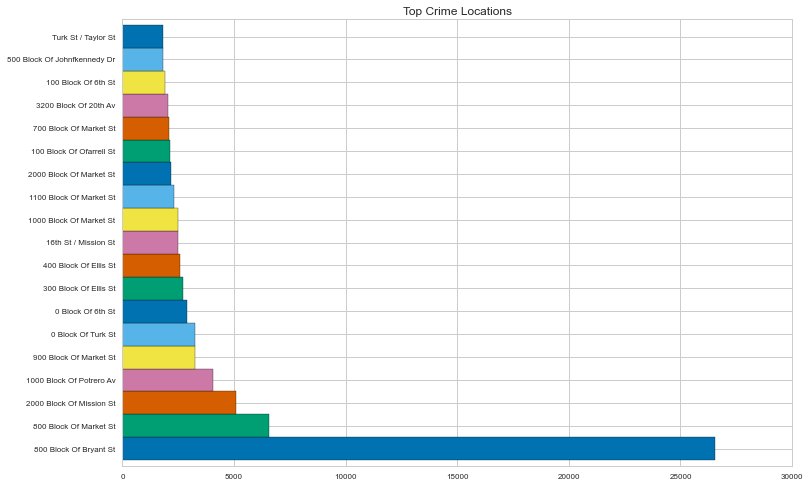

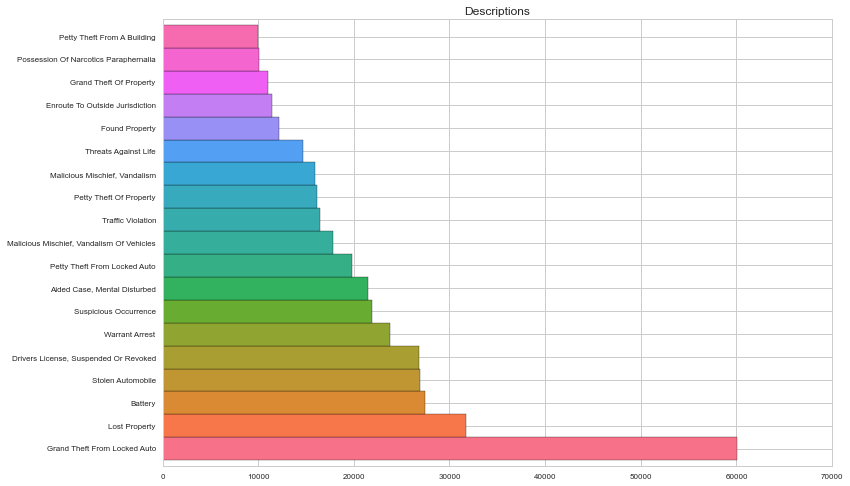

In [12]:
plot_top_crimes(data_df, 'address',    'Top Crime Locations',         'location.png', items=20)
plot_top_crimes(data_df, 'descript',   'Descriptions',                'descript.png', items=20)

##Error Analysis

We evaluate a model using: 
* loss function (this is how the kaggle competition scores our submissions)
* f1 score
* classification report (precision, recall)
* confusion matrix 

Given a model, test set and labels, the following function performs an error analysis. 

In [13]:
classes = {'VEHICLE THEFT': 36, 'SUICIDE': 31, 'WEAPON LAWS': 38, 'VANDALISM': 35, 'RECOVERED VEHICLE': 24, 
           'SECONDARY CODES': 27, 'WARRANTS': 37, 'DRUNKENNESS': 8, 'PROSTITUTION': 23, 'DRUG/NARCOTIC': 7, 
           'EMBEZZLEMENT': 9, 'TRESPASS': 34, 'FRAUD': 13, 'DRIVING UNDER THE INFLUENCE': 6, 'LOITERING': 18, 
           'ROBBERY': 25, 'GAMBLING': 14, 'BURGLARY': 4, 'OTHER OFFENSES': 21, 'FORGERY/COUNTERFEITING': 12, 
           'SUSPICIOUS OCC': 32, 'MISSING PERSON': 19, 'LIQUOR LAWS': 17, 'ARSON': 0, 'SEX OFFENSES NON FORCIBLE': 29,
           'KIDNAPPING': 15, 'ASSAULT': 1, 'BRIBERY': 3, 'SEX OFFENSES FORCIBLE': 28, 'STOLEN PROPERTY': 30, 
           'TREA': 33, 'BAD CHECKS': 2, 'FAMILY OFFENSES': 11, 'PORNOGRAPHY/OBSCENE MAT': 22, 'NON-CRIMINAL': 20, 
           'DISORDERLY CONDUCT': 5, 'EXTORTION': 10, 'RUNAWAY': 26, 'LARCENY/THEFT': 16}

classnames = [name for name in classes]

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

def print_confusion_heatmap(cm):
    plt.figure(figsize = (15.0, 10.0))
    plt.imshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def loss_function(probs, samples, num_classes, labels, classes):
    logloss = 0
    for i in range(len(labels)):
        if labels[i].isdigit():
            index = labels[i]
        else:
            index = classes[labels[i]] # this tells us which probability to take log of 
        p = probs[i, index]
        # to avoid extremes of log function: 
        pn = max(min(p,1-10^(-15)),10^(-15))
        newpart = -(np.log(pn))/samples
        logloss += newpart
    return logloss
        

def error_analysis(model, data, labels, classnames=classnames, classes=classes):
    predicted = model.predict(data)
    f1_score = metrics.f1_score(predicted, labels)
    cm = confusion_matrix(labels, predicted)
    samples = data.shape[0] # number of samples - need for loss fcn
    probs = model.predict_proba(data) # predicted probabilities of all classes, all samples
    num_classes = probs.shape[1] # number of classes, need for loss fcn
    loss = loss_function(probs, samples, num_classes, labels, classes)
    
    print "F1 score: %.5f" % f1_score
    print "Cost Function: %.5f" % loss
    print "Classification Report: "
    print(classification_report(labels, predicted, target_names=classnames))
    print_confusion_heatmap(cm)
    

##Variations on Models

In addition to feature engineering, we tried different models and different model parameters. 

###Logistic Regression Experiments

We varied logistric regression models as follows: 
* Penalty terms (we tried L1 and L2)
* Regularization parameter C 
* Convergence tolerance - there is a tradeoff between regularization and convergence; the more regularization, the longer it takes for model fit to converge

Our best model utilizes: 
* L2 penalty (the default)
* C = 0.01 (much higher regularization than the default, which is C= 1.0)
* tol = 0.01 (higher tolerance than the default, which is 0.001)

In [ ]:
lr = LogisticRegression(C=0.01, tol = 0.01)
lr.fit(crimeX, crime_labels)
print "Completed the training"

The results from the `error_analysis` function are shown below. The confusion matrix shows that the logistic regression classifier has a problem. It is predicting mostly on class label frequencies and not taking features so much into account. 

F1 score: 0.32468

Cost Function: 2.67238

Classification Report: 
                             precision    recall  f1-score   support

                    SUICIDE       0.00      0.00      0.00        15
                WEAPON LAWS       0.00      0.00      0.00       843
                    ROBBERY       0.00      0.00      0.00         6
          RECOVERED VEHICLE       0.00      0.00      0.00         1
            SECONDARY CODES       0.00      0.00      0.00       546
      SEX OFFENSES FORCIBLE       0.00      0.00      0.00        42
                   WARRANTS       0.00      0.00      0.00         8
               NON-CRIMINAL       0.00      0.00      0.00       554
               PROSTITUTION       0.00      0.00      0.00        57
              DRUG/NARCOTIC       0.00      0.00      0.00        10
               EMBEZZLEMENT       0.00      0.00      0.00         3
                   TRESPASS       0.00      0.00      0.00       158
    PORNOGRAPHY/OBSCENE MAT       0.00      0.00      0.00       172
                      FRAUD       0.00      0.00      0.00         1
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00        26
                  LOITERING       0.19      1.00      0.32      1938
                  VANDALISM       0.00      0.00      0.00        23
             MISSING PERSON       0.00      0.00      0.00        16
                   BURGLARY       0.00      0.00      0.00       277
                 BAD CHECKS       0.00      0.00      0.00       931
            STOLEN PROPERTY       0.00      0.00      0.00      1234
                  EXTORTION       0.00      0.00      0.00        70
             SUSPICIOUS OCC       0.00      0.00      0.00       252
                LIQUOR LAWS       0.00      0.00      0.00        24
                      ARSON       0.00      0.00      0.00        67
  SEX OFFENSES NON FORCIBLE       0.00      0.00      0.00        36
                 KIDNAPPING       0.00      0.00      0.00        28
                    BRIBERY       0.00      0.00      0.00         5
              VEHICLE THEFT       0.00      0.00      0.00       301
     FORGERY/COUNTERFEITING       0.00      0.00      0.00        78
                       TREA       0.00      0.00      0.00       527
                    ASSAULT       0.00      0.00      0.00      1188
            FAMILY OFFENSES       0.00      0.00      0.00       467
                DRUNKENNESS       0.00      0.00      0.00        96

                avg / total       0.04      0.19      0.06     10000



<img src="conf_lr.png">



The above confusion matrix shows that the logistic regression classifier has a problem. It is predicting mostly on class label frequencies and not taking features so much into account. 

###Neural Net Experiments

In [14]:
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

def get_model(input_dim, output_dim, wbit, dp, layers):
    keras = Sequential()
    keras.add(Dense(input_dim, wbit, init='glorot_uniform'))
    keras.add(PReLU((wbit,)))
    keras.add(Dropout(dp))

    for i in range(layers):
        keras.add(Dense(wbit, wbit, init='glorot_uniform'))
        keras.add(PReLU((wbit,)))
        keras.add(BatchNormalization((wbit,)))
        keras.add(Dropout(dp))

    keras.add(Dense(wbit, output_dim, init='glorot_uniform'))
    keras.add(Activation('softmax'))
    keras.compile(loss='categorical_crossentropy', optimizer='adam')
    return keras

input_dim = fe.train_data.shape[1]
output_dim = 39
wbit = 64
EPOCHS = 50
RUN_FOLDS = False
BATCHES = 128
nb_folds = 4
dp = 0.5
layers = 2
kfolds = KFold(len(fe.train_labels), nb_folds)
keras = get_model(input_dim, output_dim, wbit, dp, layers)

In [15]:
Y = np_utils.to_categorical(fe.train_labels)
keras.fit(fe.train_data, Y, nb_epoch=40)

Epoch 0
580000/580000 [==============================] - 39s - loss: 2.6513    
Epoch 1
580000/580000 [==============================] - 47s - loss: 2.5886    
Epoch 2
580000/580000 [==============================] - 40s - loss: 2.5755    
Epoch 3
580000/580000 [==============================] - 27s - loss: 2.5659    
Epoch 4
580000/580000 [==============================] - 64s - loss: 2.5584    
Epoch 5
580000/580000 [==============================] - 59s - loss: 2.5516    
Epoch 6
580000/580000 [==============================] - 48s - loss: 2.5451    
Epoch 7
580000/580000 [==============================] - 28s - loss: 2.5408    
Epoch 8
580000/580000 [==============================] - 28s - loss: 2.5350    
Epoch 9
580000/580000 [==============================] - 24s - loss: 2.5306    
Epoch 10
580000/580000 [==============================] - 33s - loss: 2.5270    
Epoch 11
580000/580000 [==============================] - 54s - loss: 2.5223    
Epoch 12
580000/580000 [==============

In [16]:
keras_probs = keras.predict_proba(fe.test_data, verbose=0)
print keras_probs[:1]

[[  2.62376834e-03   9.86157349e-02   4.88207407e-05   2.57076532e-04
    3.55319568e-03   4.04065369e-03   1.39799067e-02   4.51734328e-02
    8.52299703e-03   9.94313401e-05   7.20180605e-05   1.45338754e-04
    3.37770138e-03   7.41276993e-03   5.47726307e-05   2.74222863e-03
    1.26974941e-01   2.89074236e-03   1.41420594e-03   6.91259327e-03
    7.01020218e-02   2.47685665e-01   3.42464213e-06   3.77302082e-03
    3.57637571e-03   6.55769118e-02   1.75927816e-04   9.16896347e-03
    4.25397717e-03   6.30198870e-05   4.67216664e-03   1.19149997e-04
    3.02989622e-02   1.85139907e-07   1.54145049e-03   6.03390892e-02
    1.06771155e-01   4.74218590e-02   1.55443443e-02]]


In [ ]:
import gzip
with gzip.open('submission-matrix-keras-10.csv.gz', 'wb') as f:
    out = csv.writer(f, lineterminator='\n')
    out.writerow(['Id'] + list(np.unique(fe.train_labels)))
    
    for i, prob in enumerate(keras_probs):
        out.writerow([i] + list(prob))
print "Job Completed"

##Ensemble Approaches


###Random Forest Experiments

In [ ]:
clf = RandomForestClassifier(n_estimators=39, class_weight = "auto")
clf.fit(crimeX, crime_labels)
print "Random Forest Training Completed"

Below is the confusion matrix for a subset of 100,000 examples. While the result looks much better than logistic regression, the results are not good on the full test set of over 850,000 examples. The loss function computed on the test set was lower than 1.0, but the loss function on the full test set was 6. 

<img src="conf_randomF.png">

###Simple Logistic Regression and Random Forest Ensemble

This area shows some promise. The initial random forest results had loss function values around 6, and logistic regression around 2.7 We tried several simple combinations of logistic regression and random forest models, and these are an improvement on both. Results are summarized here: 

|Predicted Probability | Loss Function |
|-----|-----|
|Average of LR and RF | 2.53 on full test set |
|Maximum of LR and RF | 2.55 on full test set |

Neither of these did as well as the neural net models. Some sample code of how the ensemble is generated is below. 

In [ ]:
lr_probs = lr.predict_proba(mini_testX)
clf_probs = clf.predict_proba(mini_testX)
av_probs = (lr_probs + clf_probs)/2
print av_probs.shape

##Results and Conclusions

ALL - let's merge what we have. 